# **Step 1: Import the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression

# **Step 2: Preprocessing and data merging**

In [2]:
# Load the datasets
stock_data = pd.read_csv('stock_yfinance_data.csv')
embrizon_data = pd.read_csv('embrizon_project_1.csv')

# Preprocess dates in stock_data
try:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d-%m-%Y', errors='raise')
except ValueError:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d', errors='coerce')

if stock_data['Date'].isnull().any():
    print("Warning: Some dates in stock_data could not be parsed.")
    print(stock_data[stock_data['Date'].isnull()])

embrizon_data['Date'] = pd.to_datetime(embrizon_data['Date'].str[:10], format='%Y-%m-%d')

merged_data = embrizon_data.merge(
    stock_data,
    on=['Date', 'Stock Name'],
    how='left',
    suffixes=('', '_yfinance')
)

columns_to_copy = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
merged_data = merged_data.drop(columns=[col + '_yfinance' for col in columns_to_copy if col + '_yfinance' in merged_data])
merged_data.to_csv('merged_dataset.csv', index=False)
print("Merged dataset created successfully.")

Merged dataset created successfully.


# **Step 3: Data cleaning**

In [3]:
# Load the updated merged dataset
file_path_merged = 'merged_dataset.csv'
merged_data = pd.read_csv(file_path_merged)

# Data Cleaning
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data.sort_values('Date')
merged_data = merged_data.drop_duplicates()
merged_data = merged_data.dropna(subset=['Adj Close'])

# **Data Visualisation Of General Information**

C:\Users\SHIVAM\AppData\Local\Temp\ipykernel_11220\2737699275.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=stock_counts.index, y=stock_counts.values, palette="muted")


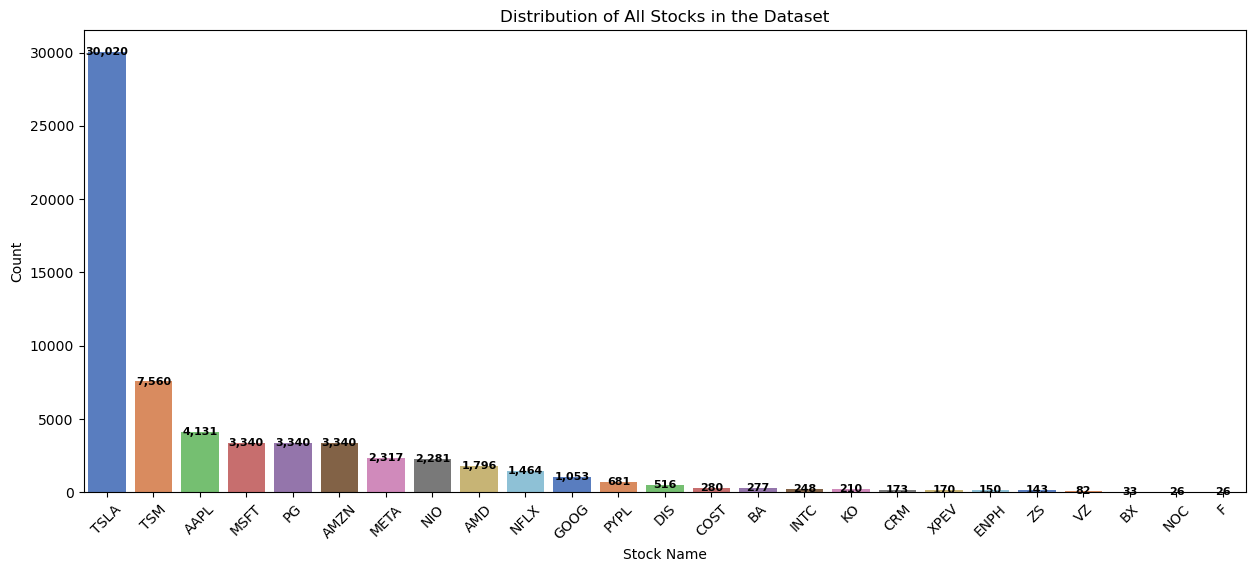

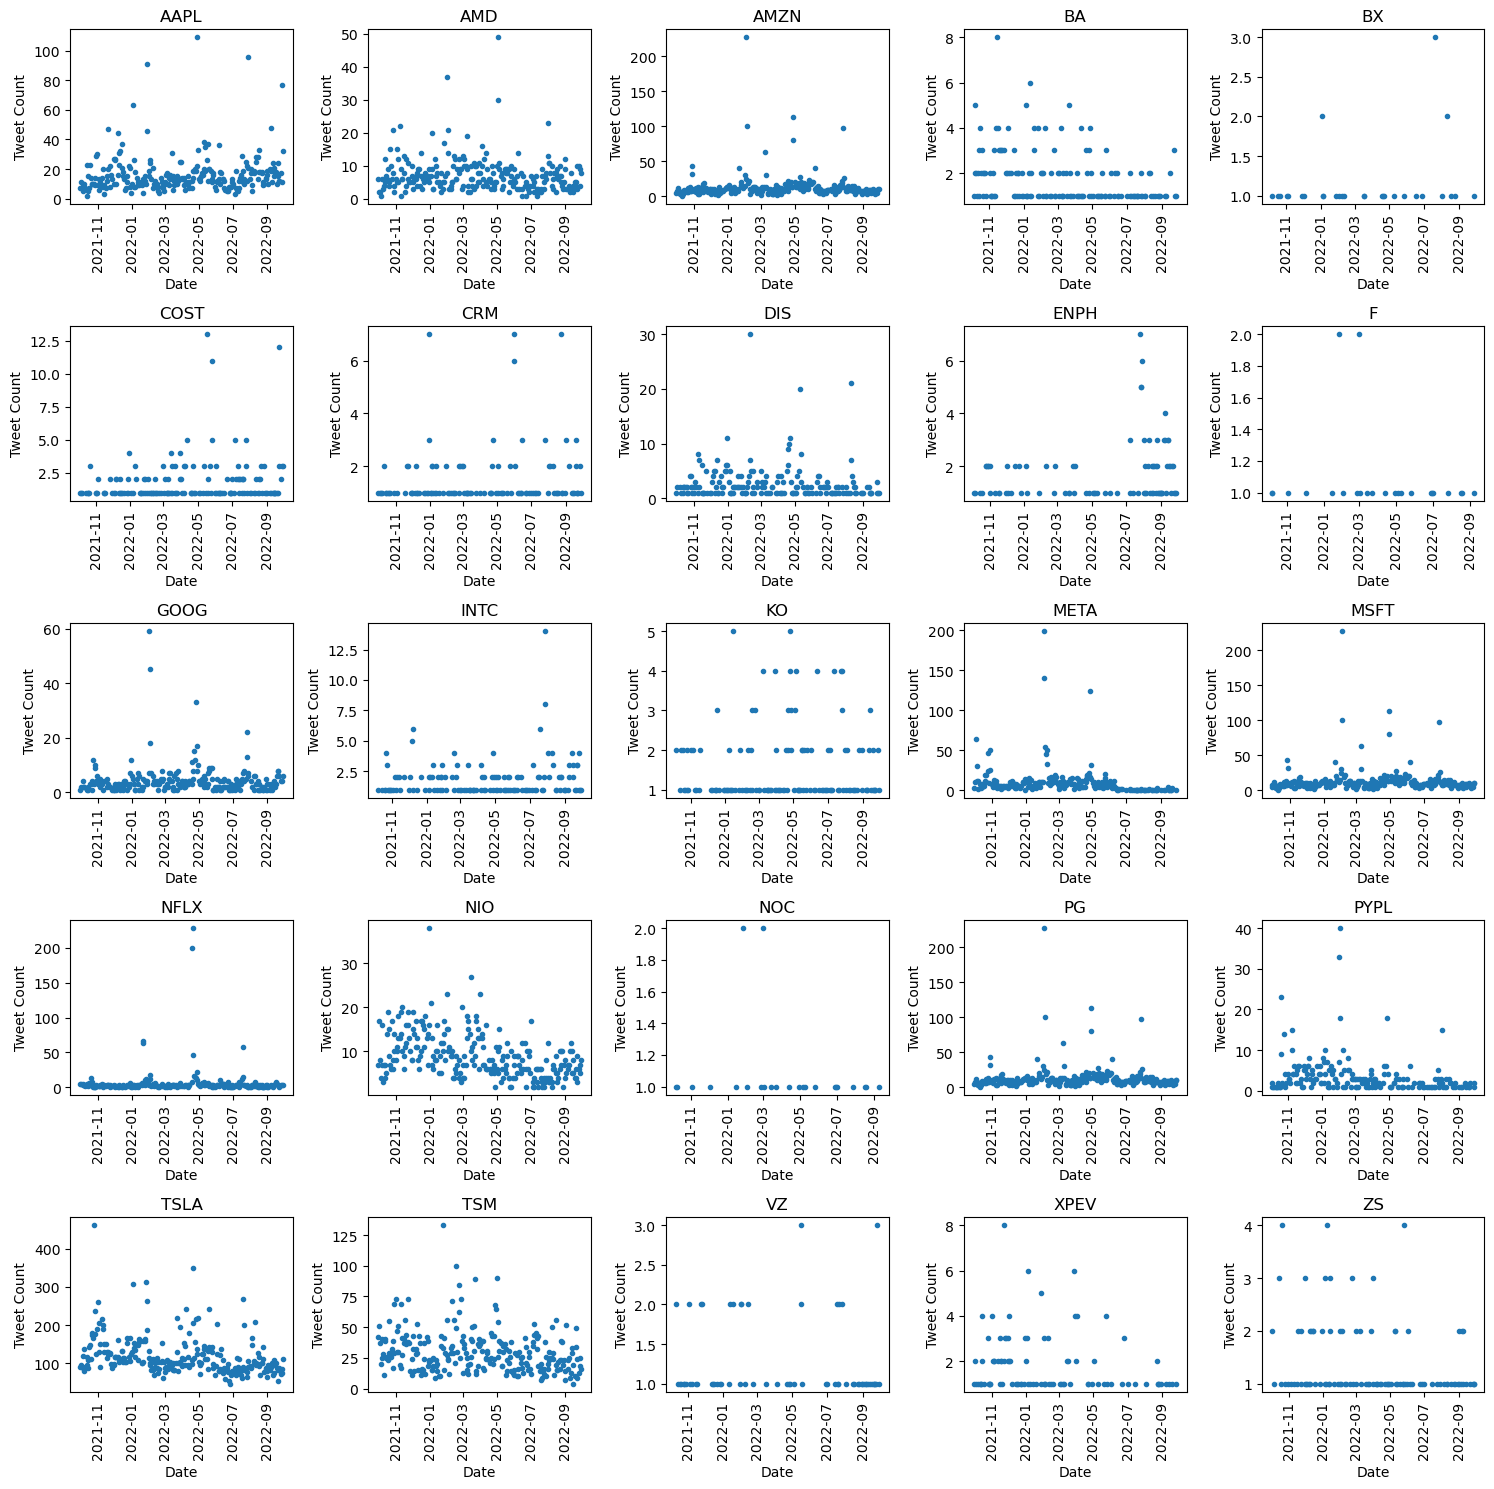

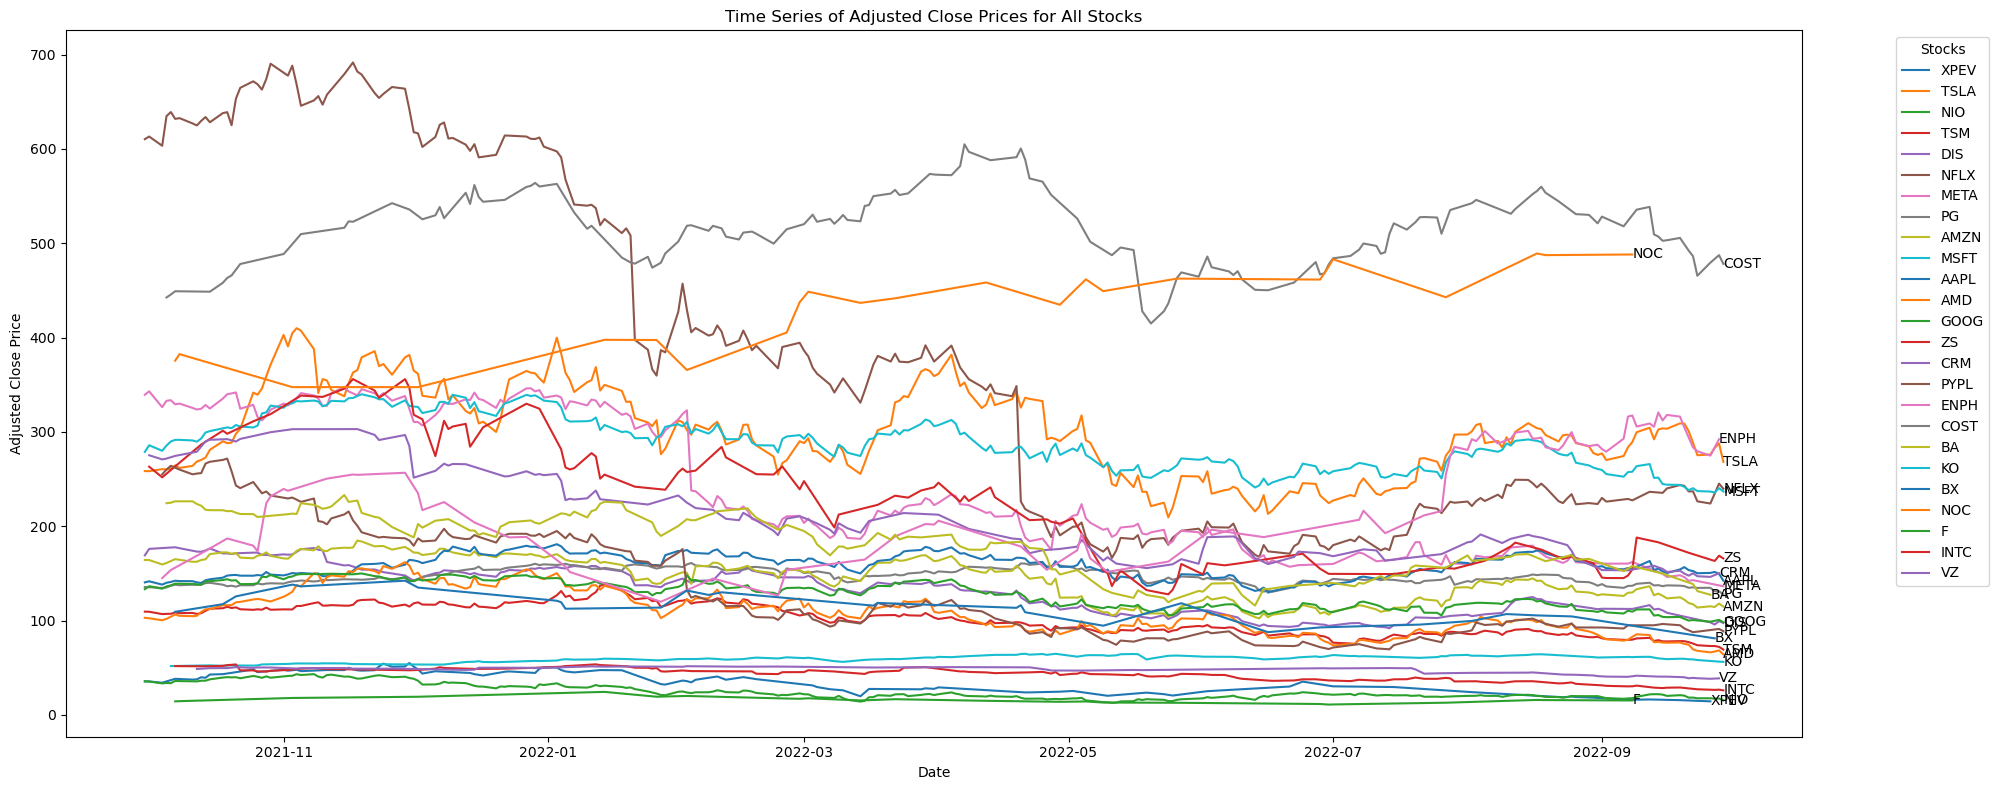

In [4]:
# Bar Graph for Distribution of All Stocks (Counts)
stock_counts = merged_data['Stock Name'].value_counts()

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=stock_counts.index, y=stock_counts.values, palette="muted")
plt.title('Distribution of All Stocks in the Dataset')
plt.xlabel('Stock Name')
plt.ylabel('Count')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=8, color='black', fontweight='bold')

plt.show()

# Tweet Trend Plots for All Stocks
def plot_company_tweets(company, id, axs, tweet_counts):

    company_data = tweet_counts[tweet_counts['Stock Name'] == company]
    axs[id].scatter(company_data['Date'], company_data['Tweet Count'], marker='.', label=f'{company} Tweet Counts')
    axs[id].set_title(f'{company}')
    axs[id].set_xlabel('Date')
    axs[id].set_ylabel('Tweet Count')
    axs[id].tick_params(axis='x', rotation=90)

tweet_counts = merged_data.groupby([merged_data['Stock Name'], merged_data['Date'].dt.date]).size().reset_index(name='Tweet Count')
companies = tweet_counts.sort_values(by='Stock Name')['Stock Name'].unique()
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()
for i, company in enumerate(companies):
    plot_company_tweets(company, i, axs, tweet_counts)
plt.tight_layout()
plt.show()

# Time-Series Graphs for Adjusted Close Prices
if 'Adj Close' in merged_data.columns:
    plt.figure(figsize=(20, 8))
    
    for stock in merged_data['Stock Name'].unique():
        stock_data = merged_data[merged_data['Stock Name'] == stock]
        plt.plot(stock_data['Date'], stock_data['Adj Close'], label=stock)
        
        # Annotate the last point with the stock name
        last_date = stock_data['Date'].iloc[-1]
        last_price = stock_data['Adj Close'].iloc[-1]
        plt.text(last_date, last_price, stock, fontsize=10, ha='left', va='center')

    plt.title('Time Series of Adjusted Close Prices for All Stocks')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# **Step 4: Sentiment Analysis**

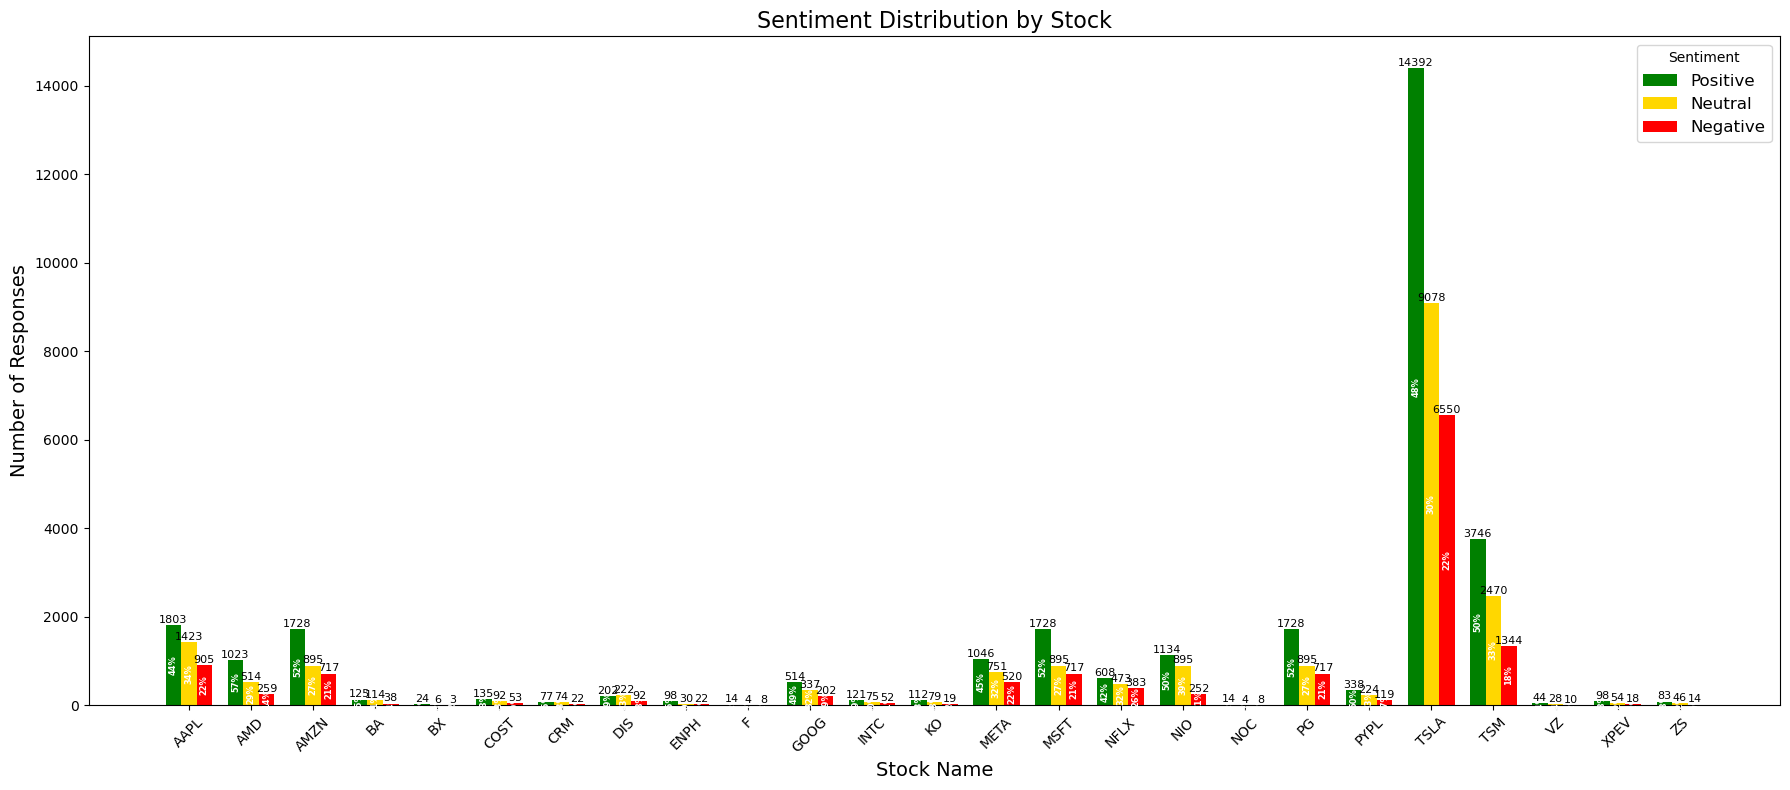

In [5]:
# Sentiment Analysis
if 'Tweet' in merged_data.columns:
    analyzer = SentimentIntensityAnalyzer()

    def calculate_sentiment(text):
        score = analyzer.polarity_scores(text)
        return score['compound']
    
    merged_data['Sentiment Score'] = merged_data['Tweet'].apply(calculate_sentiment)

    def categorize_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    merged_data['Sentiment'] = merged_data['Sentiment Score'].apply(categorize_sentiment)

    # Bar Graph showing percentages of all stocks with sentiment counts
    sentiment_counts = merged_data.groupby(['Stock Name', 'Sentiment']).size().reset_index(name='Count')
    total_counts = sentiment_counts.groupby('Stock Name')['Count'].transform('sum')
    sentiment_counts['Percentage'] = (sentiment_counts['Count'] / total_counts) * 100

    pivot_data = sentiment_counts.pivot(index='Stock Name', columns='Sentiment', values='Count').fillna(0)
    percent_data = sentiment_counts.pivot(index='Stock Name', columns='Sentiment', values='Percentage').fillna(0)

    fig, ax = plt.subplots(figsize=(18, 8))
    bar_width = 0.25
    positions = np.arange(len(pivot_data))
    colors = {'Positive': 'green', 'Neutral': 'gold', 'Negative': 'red'}

    for i, sentiment in enumerate(['Positive', 'Neutral', 'Negative']):
        values = pivot_data[sentiment].values if sentiment in pivot_data.columns else np.zeros(len(pivot_data))
        percentages = percent_data[sentiment].values if sentiment in percent_data.columns else np.zeros(len(pivot_data))
        bars = ax.bar(positions + i * bar_width, values, bar_width, label=sentiment, color=colors[sentiment])
        for bar, pct, val in zip(bars, percentages, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{pct:.0f}%", ha='center', va='center',
                    rotation=90, color='white', fontsize=6, fontweight='bold')  # Rotate percentages
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{int(val)}", ha='center', va='bottom',
                    color='black', fontsize=8)

    ax.set_title('Sentiment Distribution by Stock', fontsize=16)
    ax.set_xlabel('Stock Name', fontsize=14)
    ax.set_ylabel('Number of Responses', fontsize=14)
    ax.set_xticks(positions + bar_width)
    ax.set_xticklabels(pivot_data.index, rotation=45)
    ax.legend(title="Sentiment", fontsize=12)
    plt.tight_layout()
    plt.show()

# **Step 5: Correlation Analysis between Sentiment and Price Change**

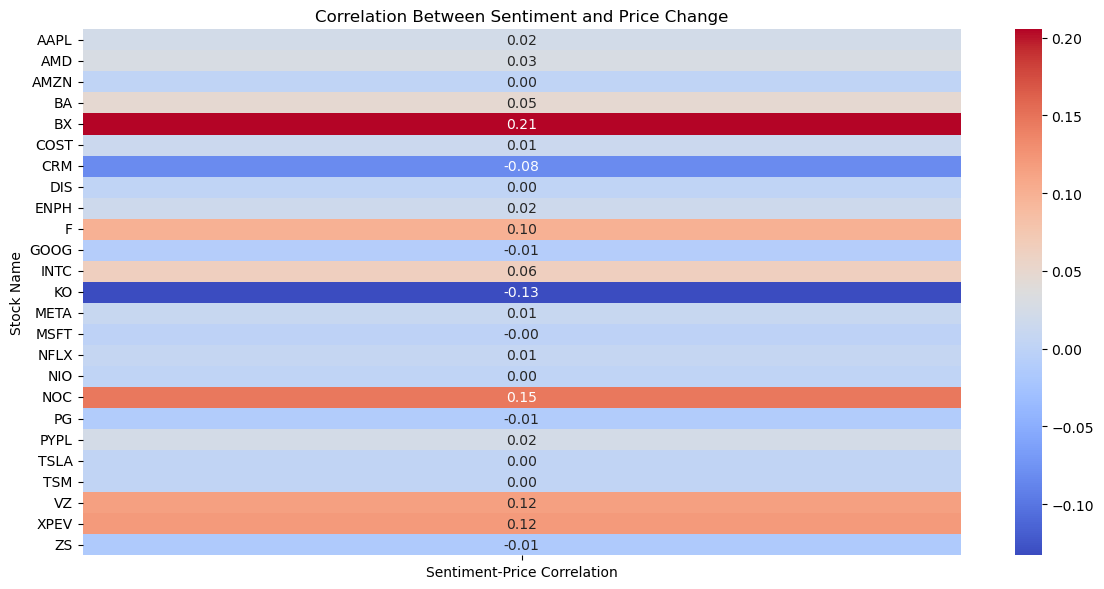

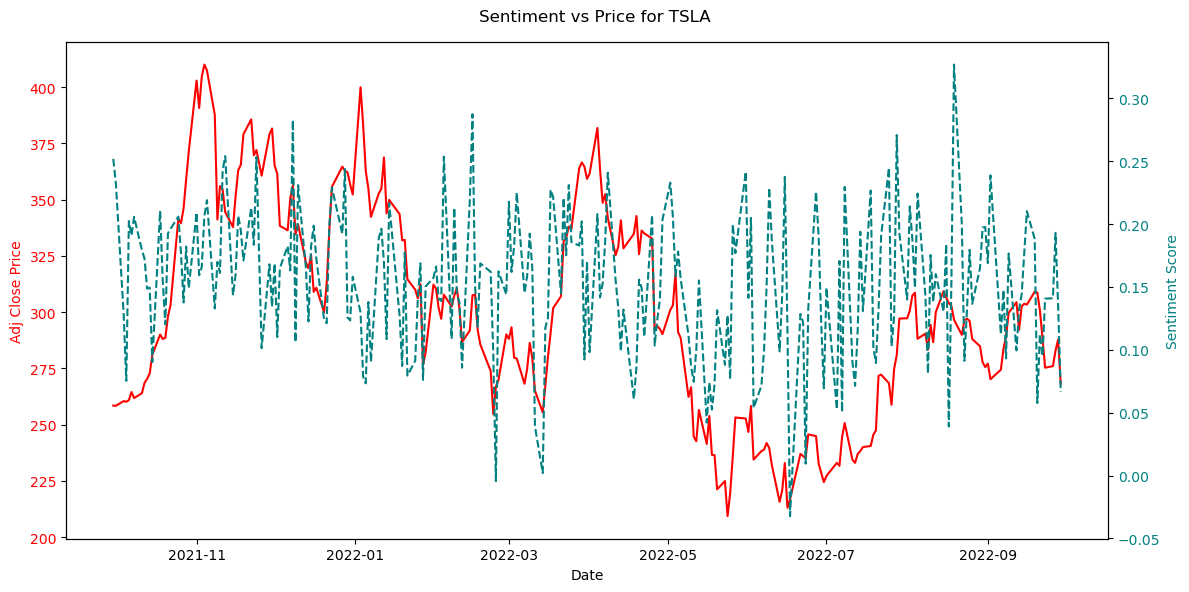

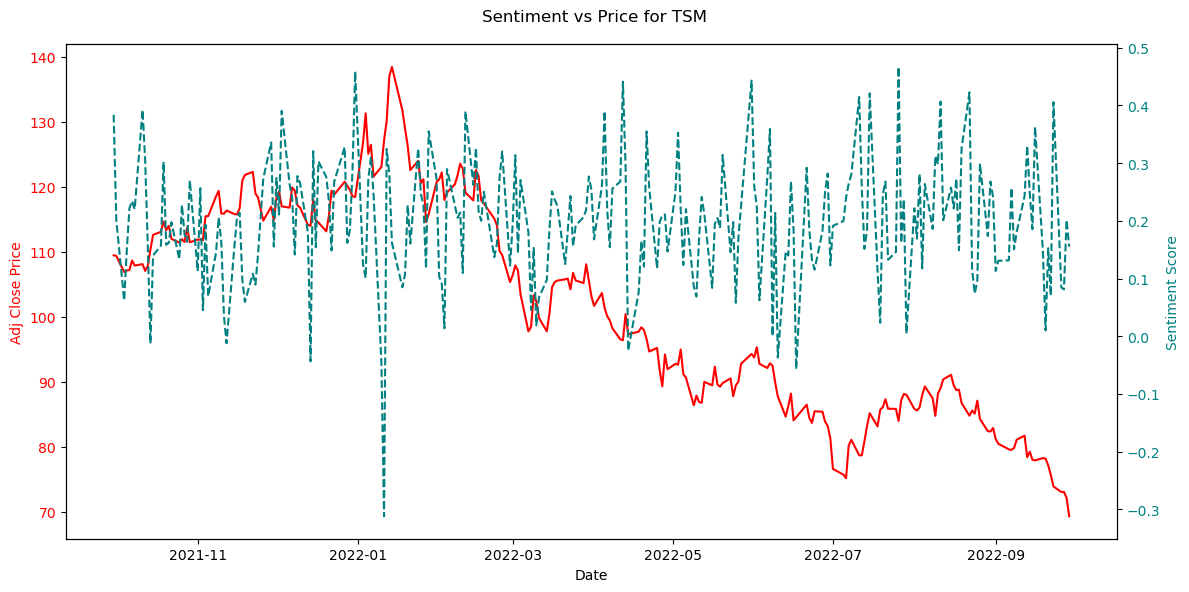

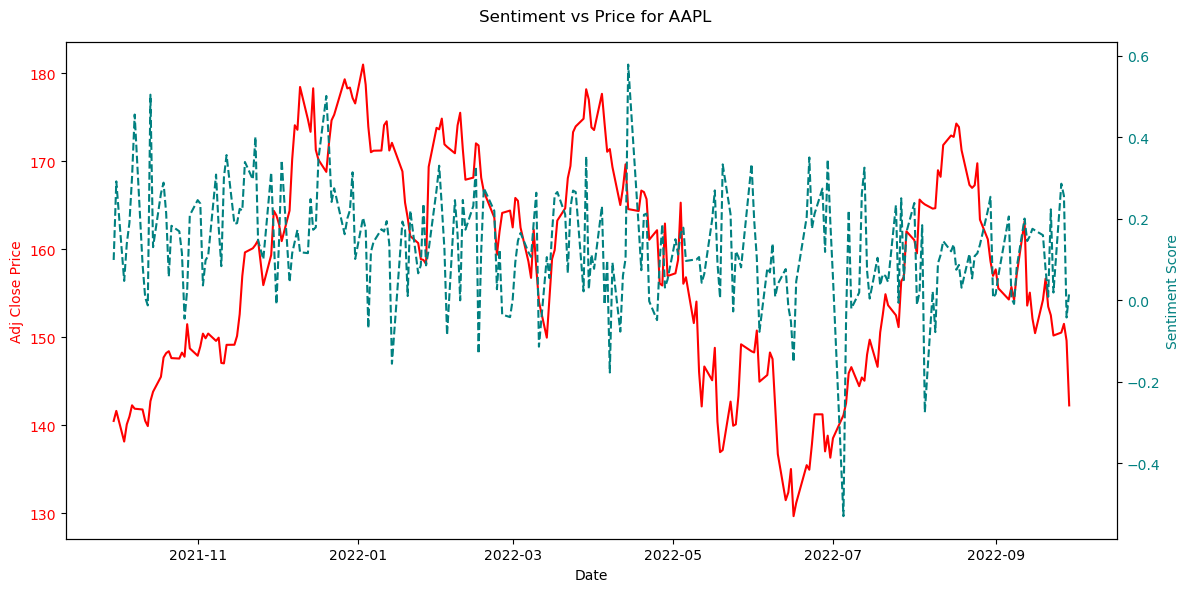

In [6]:
# Sentiment Analysis
def calculate_sentiment_scores(data):
    """Add sentiment score (VADER compound) for each tweet."""
    analyzer = SentimentIntensityAnalyzer()
    data['Sentiment Score'] = data['Tweet'].apply(
        lambda x: analyzer.polarity_scores(x)['compound']
    )
    return data

# Price Changes
def calculate_price_changes(data):
    """Add daily price change for each stock."""
    data['Price Change'] = data.groupby('Stock Name')['Adj Close'].diff()
    return data

# Correlation
def analyze_correlation(data):
    """Check correlation between sentiment score and price change for each stock."""
    grouped = data.groupby('Stock Name')
    results = []
    for stock, group in grouped:
        if group[['Sentiment Score', 'Price Change']].dropna().shape[0] > 1:
            corr = group[['Sentiment Score', 'Price Change']].corr().iloc[0, 1]
        else:
            corr = np.nan
        results.append({'Stock Name': stock, 'Sentiment-Price Correlation': corr})
    return pd.DataFrame(results)

# Heatmap Visualization
def visualize_correlation_heatmap(correlation_results):
    """Show correlation heatmap only."""
    heatmap_data = correlation_results.pivot_table(
        index='Stock Name',
        values='Sentiment-Price Correlation'
    )
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title('Correlation Between Sentiment and Price Change')
    plt.tight_layout()
    plt.show()

# Sentiment vs Price Plot
def plot_sentiment_vs_price(data, stock="TSLA"):
    """Plot average daily sentiment vs stock price for a given stock."""
    stock_data = data[data['Stock Name'] == stock].copy()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    daily = stock_data.groupby('Date').agg({
        'Sentiment Score': 'mean',
        'Adj Close': 'last'
    }).dropna()

    if daily.empty:
        print(f"⚠️ No data for {stock}")
        return

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Adj Close Price", color="red")
    ax1.plot(daily.index, daily['Adj Close'], color="red", label="Stock Price")
    ax1.tick_params(axis='y', labelcolor="red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment Score", color="teal")
    ax2.plot(daily.index, daily['Sentiment Score'], color="teal", linestyle="--", label="Sentiment")
    ax2.tick_params(axis='y', labelcolor="teal")

    fig.suptitle(f"Sentiment vs Price for {stock}")
    fig.tight_layout()
    plt.show()

# Run
merged_data = merged_data.dropna(subset=['Adj Close', 'Tweet'])
merged_data = calculate_sentiment_scores(merged_data)
merged_data = calculate_price_changes(merged_data)

correlation_results = analyze_correlation(merged_data)
visualize_correlation_heatmap(correlation_results)

for stock in merged_data['Stock Name'].value_counts().head(3).index:
    plot_sentiment_vs_price(merged_data, stock)

# **Step 6: Correlation Count**

C:\Users\SHIVAM\AppData\Local\Temp\ipykernel_11220\4199707249.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merged_data, x='Correlation Category', palette='coolwarm')


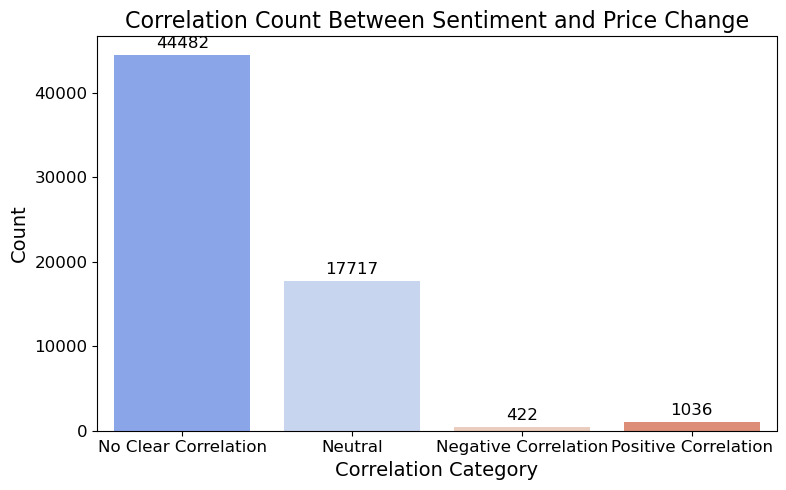

In [9]:
# Define categories for correlation
def categorize_relationship(row):
    if row['Price Change'] > 0 and row['Sentiment Score'] > 0:
        return 'Positive Correlation'
    elif row['Price Change'] < 0 and row['Sentiment Score'] < 0:
        return 'Negative Correlation'
    elif row['Sentiment Score'] == 0 and row['Price Change'] == 0:
        return 'Neutral'
    else:
        return 'No Clear Correlation'

merged_data['Correlation Category'] = merged_data.apply(categorize_relationship, axis=1)

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=merged_data, x='Correlation Category', palette='coolwarm')

# Add counts above each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=12, padding=3)

plt.title('Correlation Count Between Sentiment and Price Change', fontsize=16)
plt.xlabel('Correlation Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# **Step 7: Sentiment Prediction**

In [8]:
# Prediction Sample

X = merged_data['Tweet']
y = merged_data['Sentiment']  # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
sample_tweet = "I feel great about the TSLA stocks! They never come down!"
predicted_sentiment = model.predict([sample_tweet])[0]

print(sample_tweet)
print(f"Predicted Sentiment for sample tweet 1: {predicted_sentiment}")

sample_tweet_2 = "I feel scared about the F stocks! They never go up!"
predicted_sentiment_2 = model.predict([sample_tweet_2])[0]

print(sample_tweet_2)
print(f"Predicted Sentiment for sample tweet 2: {predicted_sentiment_2}")

I feel great about the TSLA stocks! They never come down!
Predicted Sentiment for sample tweet 1: Positive
I feel scared about the F stocks! They never go up!
Predicted Sentiment for sample tweet 2: Negative


# **Results and Conclusion**

1. **Weak overall relationship**  
   Across all analyzed stocks, there is no strong linear correlation between tweet sentiment and stock price changes. In fact, out of all tweet–price pairs, **over 44,000 cases showed no clear correlation**, and another ~17,000 were neutral (both sentiment and price change = 0).  

2. **Correlation never exceeds 0.21**  
   Even during periods of sharp price rises or falls, the correlation between daily sentiment scores and price movements remains low. The maximum observed correlation across all stocks was only **≈ 0.21**, confirming that the connection is statistically weak.  

3. **Volume of tweets does not imply correlation**  
   A higher number of tweets about a stock does not translate into stronger sentiment–price correlation. Similarly, stocks with higher prices do not show stronger correlations.  

4. **Sentiment trends vs. price trends**  
   Visual comparisons (e.g., TSLA, TSM, AAPL) show that sentiment can fluctuate independently of stock price trends. Peaks in sentiment often do not align with major price moves.  

5. **Practical implication**  
   Tweet sentiment alone is not a reliable predictor of short-term stock price changes. To improve predictive power, sentiment could be combined with other features such as trading volume, volatility, or lagged price data.  
